In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
from tqdm import tqdm
from datetime import datetime, timedelta
import time

import folium
import shapefile
from pyproj import Proj, transform

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

In [2]:
# 그래프에서 한글 사용하기
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 그래프에서 마이너스 기호 사용하기
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

# 그래프에서 datetime 데이터 사용하기
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. 데이터 전처리

## 1) 통행속도
#### 데이터 설명
- 국토교통부 openAPI 이용하여 교통정보 수집(국토교통부 교통정보공개서비스 http://openapi.its.go.kr/portal/dev/dev3.do) <br>
 - 2019년 9월 4일 ~ 8일, 오전5시~오후10시까지 1분마다 수집(-> 수집되지 못한 시간대 있음)
- now : 측정 시간
- roadsectionid : 도로구간의 고유식별번호
- avgspeed : 통행속도(시/km)
- roadnametext : 해당 도로구간의 도로명칭(id 중복됨)
- startnodeid : 도로구간 시작노드의 고유식별번호
- endnodeid : 도로구간 종료 노드의 고유식별번호
- traveltime : 통행시간(초)
- generatedate : 교통정보생성일시

### 통행속도 데이터 불러오기

In [3]:
def data_loader(path):
    """ 
    path : 파일이 저장되어 있는 디렉토리 
    """
    
    # path 내 파일 리스트 저장
    files = os.listdir(path)
    file_path = [path + '/' + file for file in files]
    
    # list에 파일 저장
    df_list = []
    if path == 'data/traffic':
        for filepath in tqdm(file_path):
            df_list.append(pd.read_csv(filepath, engine='python',parse_dates=['now']))
    elif path == 'data/weather':
        for filepath in tqdm(file_path):
            df_list.append(pd.read_csv(filepath, engine='python',parse_dates=['일시']))    

    # 병합하기
    combined_df = pd.concat(df_list, ignore_index=True, sort=False)
    
    return combined_df

In [4]:
traffic = data_loader('data/traffic')

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  4.73it/s]


In [5]:
traffic.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
traffic.head()

,avgspeed,endnodeid,generatedate,now,roadnametext,roadsectionid,startnodeid,traveltime
0,19,2000000700,2.020000e+13,2019-09-04 16:00:00,일반국도1호선,2000001102,2000000601,61
1,18,2000000601,2.020000e+13,2019-09-04 16:00:00,일반국도1호선,2000001202,2000000700,64
2,24,2000001000,2.020000e+13,2019-09-04 16:00:00,일반국도1호선,2000001501,2000000800,40
3,24,2000000800,2.020000e+13,2019-09-04 16:00:00,일반국도1호선,2000001502,2000000701,40
4,16,2000000701,2.020000e+13,2019-09-04 16:00:00,일반국도1호선,2000001503,2000000700,64


### 중복데이터 처리 후 데이터프레임 만들기
- 같은 시간에 두번 수집된 roadsectionid의 avgspeed 데이터 삭제
- index는 시간, column은 avgspeed로 데이터 프레임 만들기
- ★★★ 좀 더 효율적인 코드 짜기 ★★★

In [7]:
traffic_unique = pd.DataFrame(index = np.unique(traffic['now'])) # 데이터프레임 index를 'now'(시간)으로 설정

# column이 roadsectionid별 avgspeed가 되도록 데이터 프레임 만들기
roadsectionid = np.unique(traffic['roadsectionid'])
for road_id in roadsectionid:
    temp = traffic[traffic['roadsectionid']==road_id].drop_duplicates('now') # roadsectionid에서 시간 기준으로 중복 데이터 삭제
    traffic_unique = pd.concat([traffic_unique, temp.set_index('now')[['avgspeed']]], axis=1) # 데이터 프레임 만들기(컬럼 병합)

traffic_unique.columns = roadsectionid

### 결측값 처리
- 결측값이 많은 roadsectionid 삭제
- 결측값은 직전값과 다음값의 평균으로 채우기

#### 결측값이 많은 roadsectionid 삭제

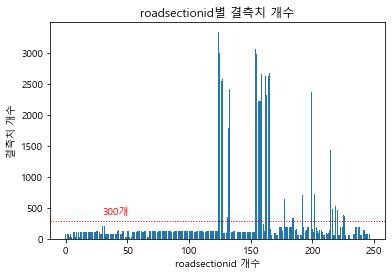

In [8]:
# 그래프로 roadsectionid별 결측값 개수 확인하기 -> 결측값이 300개를 초과하는 roadsectionid는 삭제하자
plt.bar(x=range(len(traffic_unique.columns)), height=traffic_unique.isnull().sum())
plt.axhline(y=300, color='r', linestyle=':', linewidth=1)
plt.text(30, 400, '300개', color = 'r')
plt.xlabel('roadsectionid 개수')
plt.ylabel('결측치 개수')
plt.title('roadsectionid별 결측치 개수')
plt.show()

In [9]:
# 삭제
drop_id = traffic_unique.isnull().sum()[traffic_unique.isnull().sum()>300].index
traffic_unique.drop(drop_id, axis=1, inplace=True)

#### 결측값은 직전값과 다음값의 평균으로 채우기

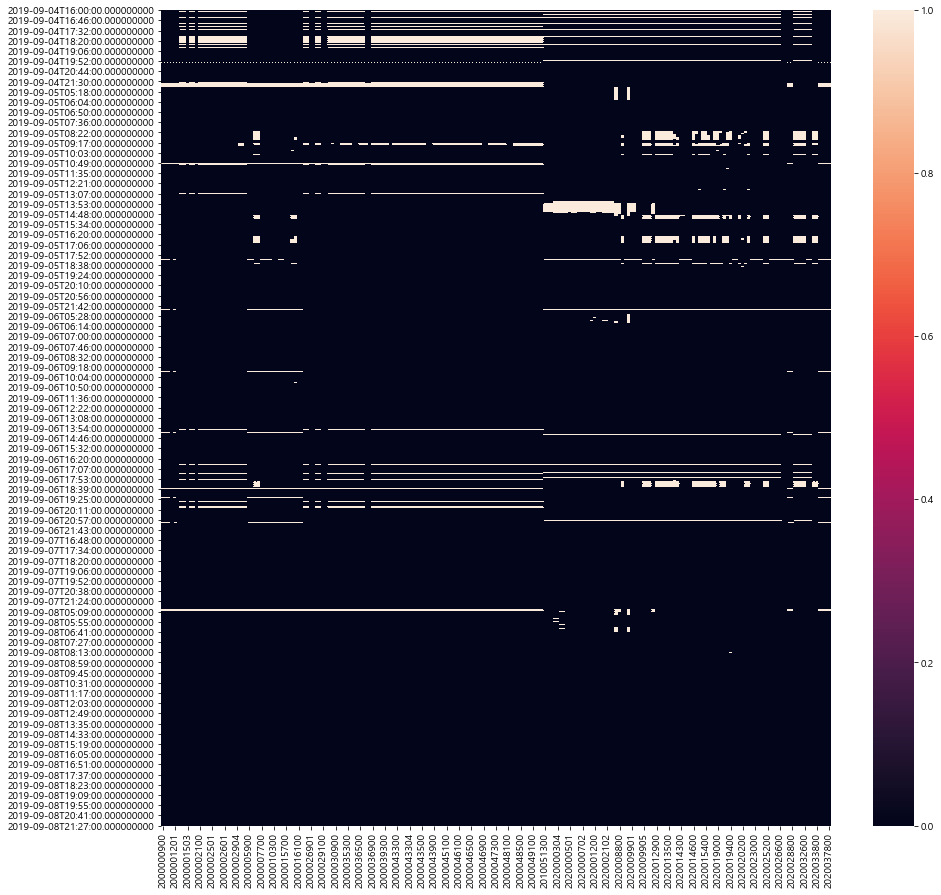

In [10]:
# 그래프로 결측값 분포 확인하기 -> 특정 시간대가 연속적으로 결측값인 경우가 있으므로 직전값/다음값의 평균으로 대체하자
plt.figure(figsize=(15,15))
sns.heatmap(traffic_unique.isnull())
plt.show()

In [11]:
# 날짜 데이터 만들기
traffic_unique['now'] = traffic_unique.index
traffic_unique['day'] = traffic_unique['now'].dt.day

# 날짜별로 직전값으로 대체. 직전값이 결측값인 경우 결측값 다음값으로 대체
traffic_ffill = traffic_unique.groupby('day').apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
 # 날짜별로 다음값으로 대체. 다음값이 결측값인 경우 직전값으로 대체
traffic_bfill = traffic_unique.groupby('day').apply(lambda x: x.fillna(method='bfill').fillna(method='ffill'))
# 직전값과 다음값의 평균
traffic_fill = (traffic_ffill.iloc[:,:-4] + traffic_bfill.iloc[:,:-4])/2

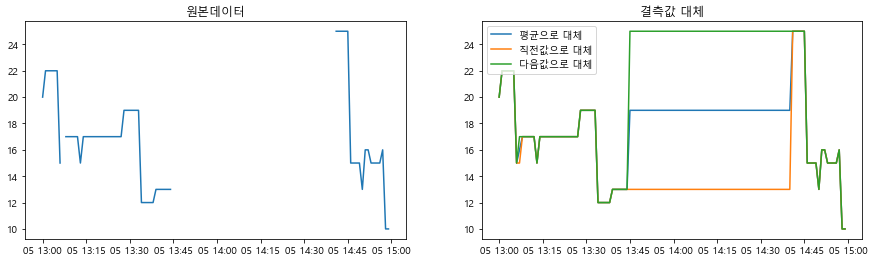

In [12]:
# 그래프로 대체 결과 확인하기(일부분만)
fig, axes = plt.subplots(ncols=2, figsize=(15,4))
axes[0].plot(traffic_unique[2020000501].loc['2019-09-05 13:00:00':'2019-09-05 14:59:00'])
axes[1].plot((traffic_fill[2020000501].loc['2019-09-05 13:00:00':'2019-09-05 14:59:00']), label='평균으로 대체')
axes[1].plot(traffic_ffill[2020000501].loc['2019-09-05 13:00:00':'2019-09-05 14:59:00'], label='직전값으로 대체')
axes[1].plot(traffic_bfill[2020000501].loc['2019-09-05 13:00:00':'2019-09-05 14:59:00'], label='다음값으로 대체')
axes[0].set_title('원본데이터')
axes[1].set_title('결측값 대체')
axes[1].legend(loc='upper left')
plt.show()

## 2) 버스
#### 데이터 설명
- 경기버스정보 제공 데이터를 웹크롤링으로 수집(경기버스정보 http://www.gbis.go.kr/gbis2014/schBus.action?mapTabCd=3)
 - 7770버스의 10개 정류장 각각 버스가 도착할 때마다 다음 버스 도착 예상 시간, 버스번호 수집
 - 데이터 로드 시 가공
- bus : 버스번호
- now : 버스 도착 시간
- pred_time : 버스 도착 예상 소요 시간(분, 경기버스정보 제공 데이터)
- actual_time : 버스 도착 실제 소요 시간(분)
- error : 예상 시간과 소요 시간과의 차이(분)
- bus_stop : 버스 정류장

### 버스데이터 로드 및 가공

In [13]:
def data_loader_bus(path):
    """ 
    path : 파일이 저장되어 있는 디렉토리 
    """
    
    # path 내 파일 리스트 저장
    files = os.listdir(path)
    file_path = [path + '/' + file for file in files]
    
    # list에 파일 저장
    df_list = []
    for filepath in tqdm(file_path):
        temp = pd.read_csv(filepath, engine='python',parse_dates=['now'])
        temp.drop('Unnamed: 0', axis=1, inplace=True) # 필요없는 컬럼 삭제
        temp.columns = ['bus', 'now', 'pred_time']     # 컬럼명 변경
        
        # 실제 도착 소요 시간 계산 및 도착 예상 시간 재정렬
        actual_time = (temp['now'][1:].reset_index(drop=True) - temp['now'][:-1].reset_index(drop=True)) // np.timedelta64(1, 'm')
        pred_time = temp['pred_time'][:-1].reset_index(drop=True)

        # 첫번째 열 삭제 후 새로운 열 생성(실제 도착 소요 시간, 도착 예상 시간, 오차값, 정류장)
        temp = temp.drop(0).reset_index(drop=True)
        temp['pred_time'] = pred_time
        temp['actual_time'] = actual_time
        temp['error'] = actual_time - pred_time
        temp['bus_stop'] = filepath.split('/')[2].split('_')[2].split('.')[0]
        
        df_list.append(temp)
    
    # 병합하기
    combined_df = pd.concat(df_list, ignore_index=True, sort=False)
    
    return combined_df

In [14]:
bus = data_loader_bus('data/bus')

100%|█████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 139.56it/s]


In [15]:
bus.head()

,bus,now,pred_time,actual_time,error,bus_stop
0,경기70사1126,2019-09-04 16:37:00,5,9,4,경기일보
1,경기70사1142,2019-09-04 16:44:00,6,7,1,경기일보
2,경기70사1154,2019-09-04 16:46:00,1,2,1,경기일보
3,경기70사1155,2019-09-04 16:49:00,2,3,1,경기일보
4,경기70사1189,2019-09-04 16:54:00,5,5,0,경기일보


## 3) 날씨
데이터 설명
- 기상청 기상자료개방포털에서 수원시 기상 데이터 다운로드 (https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36)
- 1시간 단위로 데이터 제공
- 총 34가지 데이터 중 기온, 강수량, 습도, 이슬점온도, 풍속 선택

In [16]:
weather = data_loader('data/weather')

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 172.95it/s]


In [17]:
weather.head(3)

,지점,일시,기온(°C),기온 QC플래그,강수량(mm),강수량 QC플래그,풍속(m/s),풍속 QC플래그,풍향(16방위),풍향 QC플래그,...,최저운고(100m ),시정(10m),지면상태(지면상태코드),현상번호(국내식),지면온도(°C),지면온도 QC플래그,5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
0,119,2019-09-04 01:00:00,23.2,NaN,NaN,NaN,2.2,NaN,90,NaN,...,22.0,2000,NaN,NaN,21.8,NaN,NaN,NaN,NaN,NaN
1,119,2019-09-04 02:00:00,23.3,NaN,NaN,NaN,1.6,NaN,90,NaN,...,21.0,2000,NaN,NaN,21.9,NaN,NaN,NaN,NaN,NaN
2,119,2019-09-04 03:00:00,23.3,NaN,NaN,NaN,1.9,NaN,90,NaN,...,10.0,2000,NaN,NaN,21.8,NaN,NaN,NaN,NaN,NaN


In [18]:
weather = weather[['일시','기온(°C)','강수량(mm)','습도(%)','이슬점온도(°C)','풍속(m/s)']]
weather.columns = ['date','temperature','rain','humidity','dew_point_temperature','windspeed']

In [19]:
weather.fillna(0, inplace=True) # 강수량 결측값 대체 -> 0인 경우가 결측값이므로 0으로 대체

In [20]:
weather.head()

,date,temperature,rain,humidity,dew_point_temperature,windspeed
0,2019-09-04 01:00:00,23.2,0.0,86,20.7,2.2
1,2019-09-04 02:00:00,23.3,0.0,86,20.8,1.6
2,2019-09-04 03:00:00,23.3,0.0,84,20.4,1.9
3,2019-09-04 04:00:00,23.4,0.0,83,20.3,2.3
4,2019-09-04 05:00:00,23.5,0.0,82,20.2,4.0


## 4) 데이터 병합

#### 버스-날씨

In [21]:
# 데이터 병합용 변수 생성('날짜-시간')
bus['day_hour'] = bus['now'].dt.day.astype(str) + '-' + bus['now'].dt.hour.astype(str)
weather['day_hour'] = weather['date'].dt.day.astype(str) + '-' + weather['date'].dt.hour.astype(str)

#### 버스-통행속도
- 버스데이터의 '도착시간' 기준 이전 5분간의 평균 통행속도 구하기

In [22]:
# 버스 '도착시간' 기준 이전 5분동안 통행속도 데이터가 몇 개 있는지 확인
temp = []
for t in bus['now']:
    temp.append([len(traffic_fill.loc[t-timedelta(minutes=4) : t]), t]) # temp.append([통행속도 데이터 개수], 도착시간)
temp = np.array(temp)

np.unique(temp[:,0], return_counts=True)

(array([0, 1, 3, 4, 5], dtype=object),
 array([  78,    1,   11,   21, 3067], dtype=int64))

In [23]:
# 버스 데이터에서 통행속도 데이터가 없는 78개 데이터 삭제하기
drop_idx = bus[bus['now'].isin(temp[:,1][temp[:,0]==0])].index
bus.drop(drop_idx, inplace = True)
bus.reset_index(drop=True, inplace=True)

In [24]:
# 버스 데이터의 '도착시간' 기준 이전 5분간의 평균 통행속도 구하기 ★★★ 좀 더 효율적인 코드 짜기 ★★★
traffic = pd.DataFrame(columns=traffic_fill.columns)
for i,t in enumerate(bus['now']):
    traffic.loc[i] = traffic_fill.loc[t - timedelta(minutes=4) : t].mean()

### 데이터 병합

In [25]:
# 버스-날씨
data = pd.merge(bus,weather, on='day_hour')
data.drop(['day_hour','date'], axis=1, inplace=True)

# 버스-날씨-통행속도
data = pd.concat([data, traffic], axis=1)

In [26]:
# 변수 생성
data['day'] = data['now'].dt.day
data['hour'] = data['now'].dt.hour
data['min'] = data['now'].dt.minute
data['dayofweek'] = data['now'].dt.dayofweek
data['weekend'] = np.where(data['dayofweek'].isin([5,6]),1,0)

# 2. EDA

## 1) 예상 소요 시간, 실제 소요 시간, 오차, 버스 정류장
- 정류장 중 '글로벌청소', '고등동주민센터'는 수집 과정에서의 문제로 많이 없음

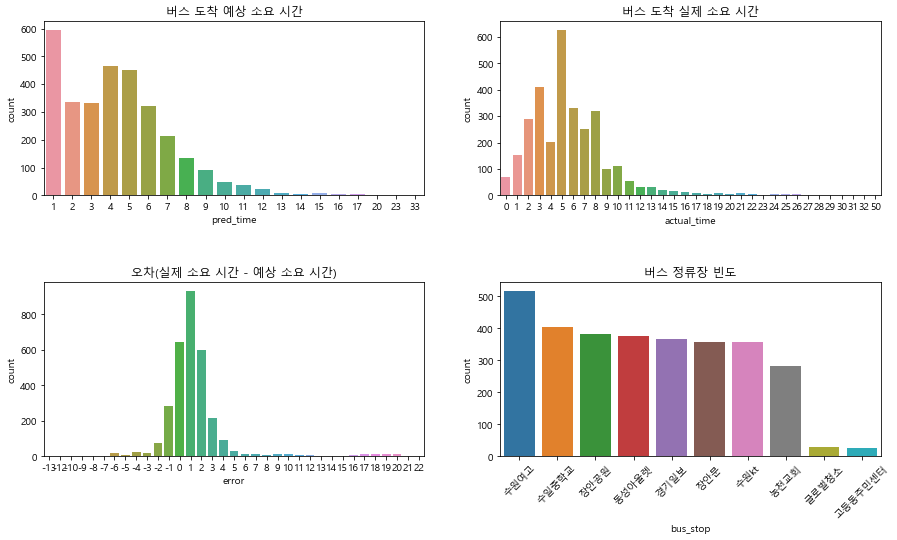

In [27]:
bus_stop_order = data['bus_stop'].value_counts().index

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,8))
sns.countplot(x='pred_time', data=data, ax=axes[0][0])
sns.countplot(x='actual_time', data=data, ax=axes[0][1])
sns.countplot(x='error', data=data, ax=axes[1][0])
sns.countplot(x='bus_stop', data=data, order = bus_stop_order,ax=axes[1][1])
axes[0][0].set_title('버스 도착 예상 소요 시간')
axes[0][1].set_title('버스 도착 실제 소요 시간')
axes[1][0].set_title('오차(실제 소요 시간 - 예상 소요 시간)')
axes[1][1].set_title('버스 정류장 빈도')
plt.xticks(rotation=45)
plt.subplots_adjust(wspace = 0.2,hspace = 0.5)
plt.show()

### 예상 소요 시간, 실제 소요시간, 오차
- 예상 소요 시간과 오차와의 선형 관계는 크지 않았음

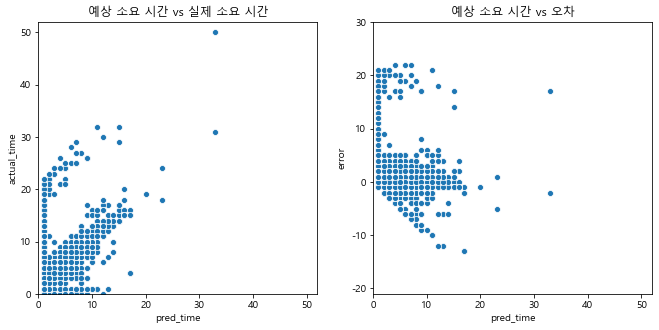

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(11,5))
sns.scatterplot('pred_time','actual_time', data=data, ax=axes[0])
sns.scatterplot('pred_time','error', data=data, ax=axes[1])
axes[0].set_xlim([0,52])
axes[0].set_ylim([0,52])
axes[1].set_xlim([0,52])
axes[1].set_ylim([-21,30])
axes[0].set_title('예상 소요 시간 vs 실제 소요 시간')
axes[1].set_title('예상 소요 시간 vs 오차')
plt.show()

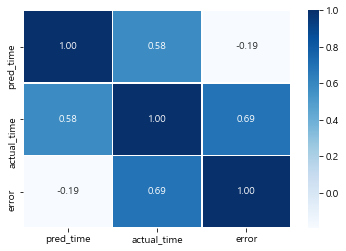

In [29]:
# 예상 소요 시간, 실제 소요 시간, 오차의 상관계수
heatmap = sns.heatmap(data[['pred_time','actual_time','error']].corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
heatmap.set_ylim(3,0)
plt.show()

### 버스정류장, 오차
- '농천교회' 정류장은 예상 소요 시간이 1분인 경우가 많았으나 오차가 6분 이상인 경우 중 대부분을 차지함
- => 오차의 대부분은 '농천교회' 정류장에서 발생함을 알 수 있음!
- 농천교회는 수원역(종점) 바로 직전 정류장(하행)

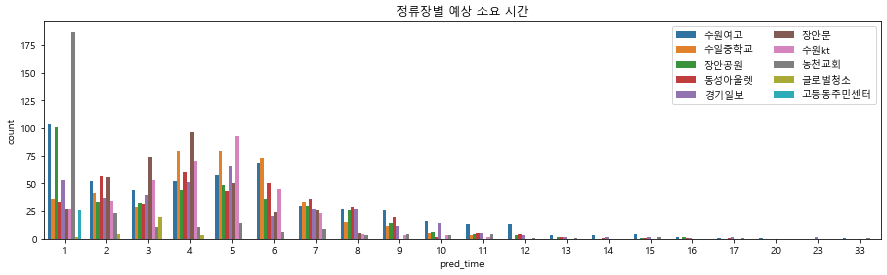

In [30]:
# 정류장별 예상 소요 시간 -> '농천교회' 정류장은 예상 소요 시간이 1분인 경우가 많음
fig, axes = plt.subplots(figsize=(15,4))
sns.countplot(x='pred_time', data=data, hue='bus_stop', hue_order=bus_stop_order)
plt.legend(ncol=2, loc='upper right')
plt.title('정류장별 예상 소요 시간')
plt.show()

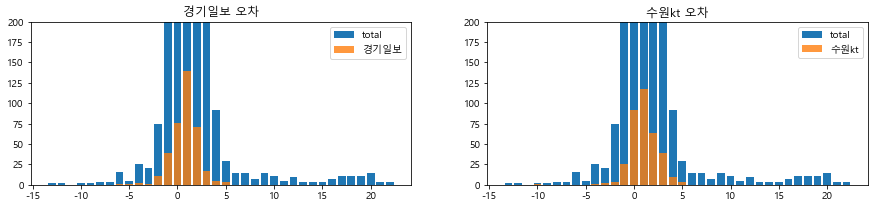

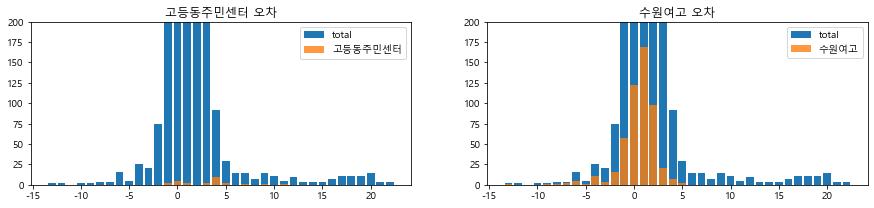

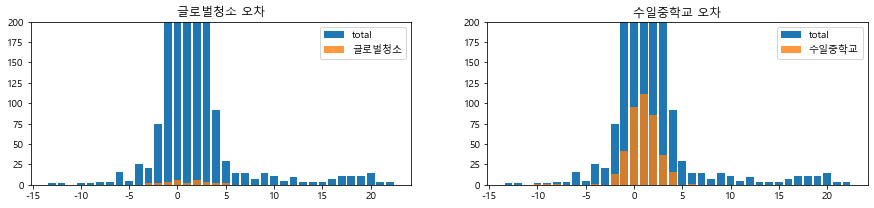

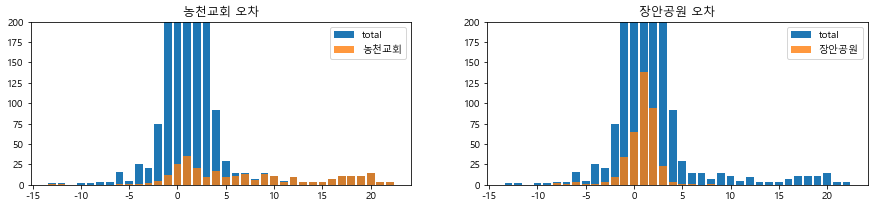

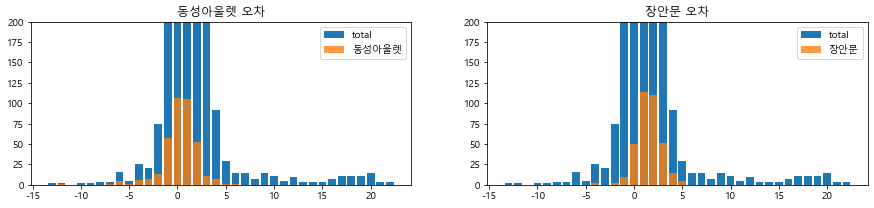

In [31]:
# 정류장별 오차 -> '농천교회' 정류장이 오차가 6분 이상인 경우 중 대부분을 차지함

for bus_stop1, bus_stop2 in zip(np.unique(data['bus_stop'])[:5],np.unique(data['bus_stop'])[5:]):
    tot = data['error'].value_counts()
    temp1 = data['error'][data['bus_stop']==bus_stop1].value_counts()
    temp2 = data['error'][data['bus_stop']==bus_stop2].value_counts()
    
    fig, axes = plt.subplots(ncols=2, figsize=(15,3))
    axes[0].bar(tot.index, tot, label='total')
    axes[0].bar(temp1.index, temp1, label=bus_stop1, alpha=0.8)
    axes[1].bar(tot.index, tot, label='total')
    axes[1].bar(temp2.index, temp2, label=bus_stop2, alpha=0.8)
    axes[0].set_ylim([0,200])
    axes[1].set_ylim([0,200])
    axes[0].legend(loc='best')
    axes[1].legend(loc='best')            
    axes[0].set_title(f'{bus_stop1} 오차')
    axes[1].set_title(f'{bus_stop2} 오차')
    plt.show()

In [32]:
# 오차가 6분 이상인 정류장 빈도
data['bus_stop'][data['error']>=6].value_counts()

농천교회       139
고등동주민센터      3
장안공원         2
동성아울렛        1
수일중학교        1
Name: bus_stop, dtype: int64

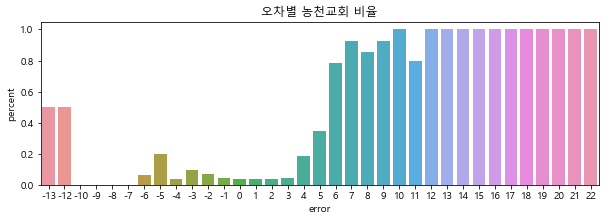

In [33]:
# 오차에서 농천교회가 차지하는 비율

result = data['error'][data['bus_stop']=='농천교회'].value_counts().sort_index() / data['error'].value_counts().sort_index()

plt.figure(figsize=(10,3))
sns.barplot(result.index, result)
plt.xlabel('error')
plt.ylabel('percent')
plt.title('오차별 농천교회 비율')
plt.show()

In [34]:
# 정류장별 위치 확인 -> 농천교회는 수원역(종점) 바로 직전 정류장(하행)
## 빨간색 아이콘 : 농천교회 정류장 위치
## 녹색 아이콘 : 이외 정류장 위치
## 파란색 원 : 수원역 위치

map1 = folium.Map(location=[37.288719, 127.012743], zoom_start=13, tiles='Stamen Terrain')
folium.Marker([37.282298, 127.006051], icon=folium.Icon(color='green'), popup='고등동주민').add_to(map1)
folium.Marker([37.271264, 127.000983], icon=folium.Icon(color='green'), popup='글로벌청소년드림센터.경기도지사공관').add_to(map1)
folium.Marker([37.291406, 127.012585], icon=folium.Icon(color='green'), popup='장안문').add_to(map1)
folium.Marker([37.300600, 127.008741], icon=folium.Icon(color='green'), popup='수원kt위').add_to(map1)
folium.Marker([37.30722,  126.999858], icon=folium.Icon(color='green'), popup='수일중학교').add_to(map1)
folium.Marker([37.304133, 127.004900], icon=folium.Icon(color='green'), popup='경기일보').add_to(map1)
folium.Marker([37.29153,  127.012035], icon=folium.Icon(color='green'), popup='동성아울렛').add_to(map1)
folium.Marker([37.288719, 127.012743], icon=folium.Icon(color='green'), popup='장안공원').add_to(map1)
folium.Marker([37.276077, 127.002797], icon=folium.Icon(color='green'), popup='수원여고').add_to(map1)
folium.Marker([37.2710, 127.000619], icon=folium.Icon(color='red'), popup='농천교회').add_to(map1)
folium.CircleMarker([37.266837, 126.999346],radius=20, color='blue',fill_color='blue', popup='수원역').add_to(map1)
map1

### 버스번호, 오차
- 버스에 따라 일찍/늦게 도착하는 경우가 있었으나 유의미한 분석 결과를 얻을 수 없었음
- 샘플 수를 보충하고, 가능하다면 운전 기사님의 특성 등을 추가 수집 후 분석하면 유의미한 결과가 나올 수도 있을 듯

## 2)날씨
- 온도와 습도/이슬점은 선형관계
- 이외에는 선형관계가 거의 없음

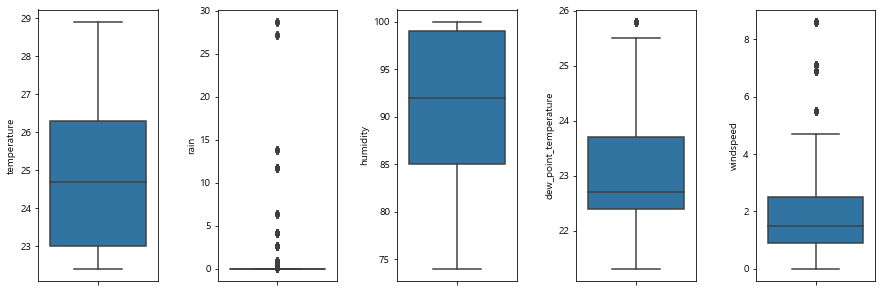

In [35]:
# 날씨 데이터의 box plot
fig, axes = plt.subplots(ncols=5, figsize=(15,5))
sns.boxplot(y='temperature', data=data, ax=axes[0])
sns.boxplot(y='rain', data=data, ax=axes[1])
sns.boxplot(y='humidity', data=data, ax=axes[2])
sns.boxplot(y='dew_point_temperature', data=data, ax=axes[3])
sns.boxplot(y='windspeed', data=data, ax=axes[4])
plt.subplots_adjust(wspace = 0.5)
plt.show()

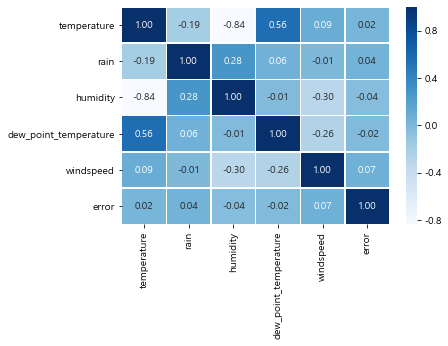

In [36]:
# 날씨 데이터와 오차의 상관관계
heatmap = sns.heatmap(data[['temperature','rain','humidity','dew_point_temperature','windspeed','error']].corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
heatmap.set_ylim(6,0)
plt.show()

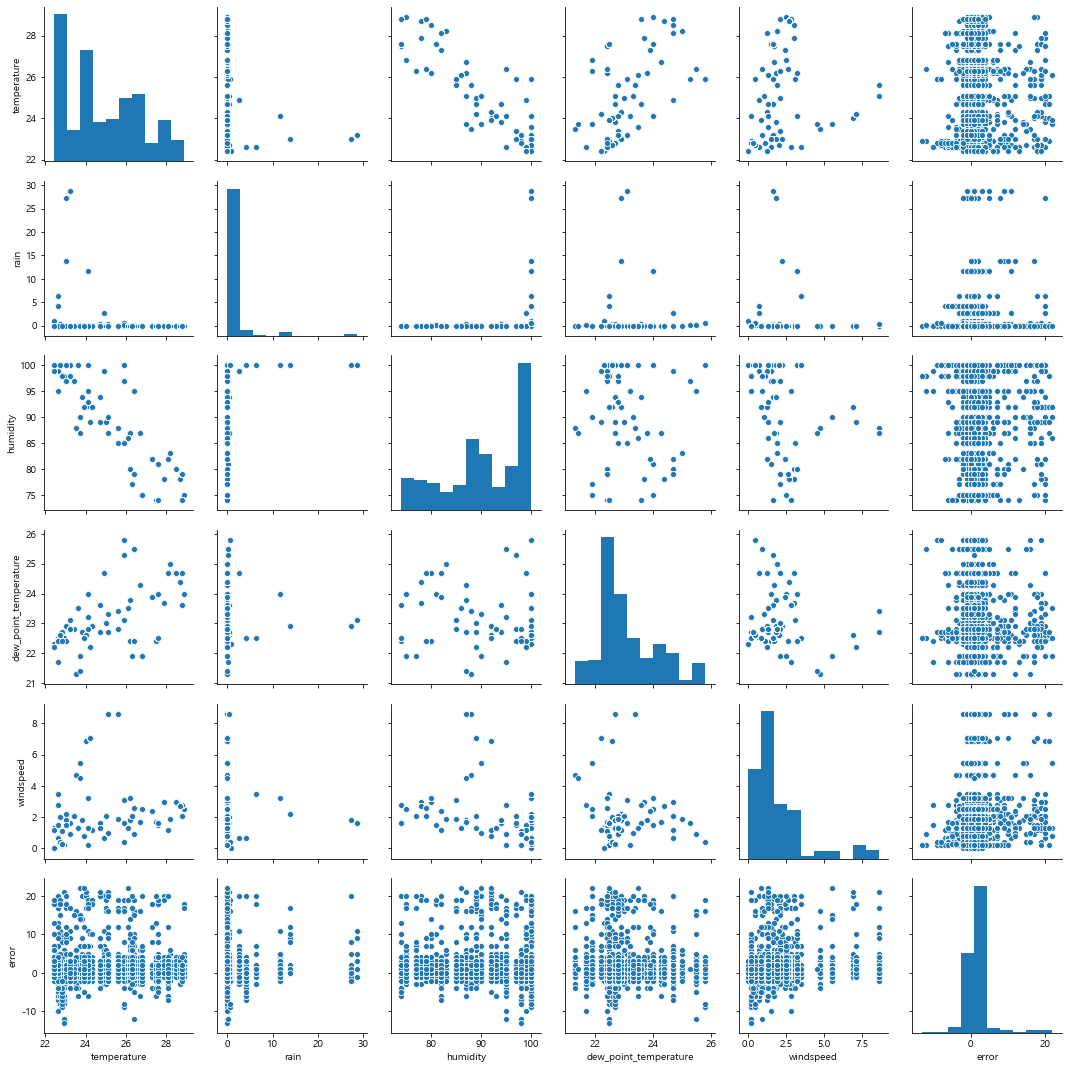

In [37]:
# 날씨 데이터와 오차의 산점도
sns.pairplot(data[['temperature','rain','humidity','dew_point_temperature','windspeed','error']])
plt.show()

## 3) 통행속도
- 수집한 통행속도 데이터의 roadsectionid의 위도/경도를 구하기 위해 전국표준노드링크 데이터를 사용

#### 전국표준노드링크 데이터 불러오기

In [34]:
shp_path_node = '전국표준노드링크_2019_09_20/MOCT_NODE.shp'
sf_node = shapefile.Reader(shp_path_node, encoding="cp949")
shp_path_link = '전국표준노드링크_2019_09_20/MOCT_LINK.shp'
sf_link = shapefile.Reader(shp_path_link, encoding="cp949")

#### 전국표준노드링크를 데이터프레임으로 만들기

In [35]:
# node
fields_node = [x[0] for x in sf_node.fields][1:]
records_node = sf_node.records()
shps = [s.points for s in sf_node.shapes()] # node has coordinate data.
node_dataframe = pd.DataFrame(columns=fields_node, data=records_node)
node_dataframe = node_dataframe.assign(coords=shps) # add the coordinate data to a column called "coords"

# link
fields_link = [x[0] for x in sf_link.fields][1:]
records_link = sf_link.records()
link_dataframe = pd.DataFrame(columns=fields_link, data=records_link)

#### data에 있는 roadsectionid(cols)만 추출하기
- 노드 및 링크의 식별자(id)는 권역번호(3자리), 일련번호(5자리), 장래확장자(2자리)로 구성된 10자리 숫자임<br>
http://nodelink.its.go.kr/intro/intro06_05.aspx

In [36]:
# roadsectionid 저장
cols = data.columns[11:-5].astype(str)

In [37]:
# roadsectionid 데이터만 담은 새로운 link 데이터 프레임 만들기 (link_df_suwon)
link_df_suwon = link_dataframe.copy()
link_df_suwon = link_df_suwon[link_df_suwon['LINK_ID'].isin(cols)]
link_df_suwon.reset_index(drop=True, inplace=True)

In [38]:
# link_df_suwon에 있는 node 저장 변수
suwon_nodes = pd.concat([link_df_suwon['F_NODE'], link_df_suwon['T_NODE']], axis=0)

# roadsectionid 데이터만 담은 새로운 node 데이터 프레임 만들기 (link_df_suwon)
node_df_suwon = node_dataframe.copy()
node_df_suwon = node_df_suwon[node_df_suwon['NODE_ID'].isin(suwon_nodes)]
node_df_suwon.reset_index(drop=True, inplace=True)

#### 위도/경도 변환하기
- 전국표준노드링크데이터는 korea 2000 좌표를 사용 -> wgs84(GPS용) 좌표로 변환해야 함

In [40]:
inProj = Proj(init = 'epsg:5186') # korea 2000
outProj= Proj(init = 'epsg:4326') # wgs84
node_df_suwon['coords'] = node_df_suwon['coords'].apply(lambda x: transform(inProj,outProj,x[0][0],x[0][1]))
node_df_suwon['coords'] = node_df_suwon['coords'].apply(lambda x: (x[1], x[0]))

#### 시각화하기

In [42]:
coords = node_df_suwon.set_index('NODE_ID')['coords']

F_NODE_coords = link_df_suwon['F_NODE'].map(coords)
T_NODE_coords = link_df_suwon['T_NODE'].map(coords)

map_lat = node_df_suwon['coords'].str[0].mean()
map_lon = node_df_suwon['coords'].str[1].mean()

In [266]:
map_suwon = folium.Map(location=(map_lat, map_lon), zoom_start=13, tiles='Stamen Terrain')   

kw = {'opacity': 0.5, 'weight': 5}
for start, end in zip(F_NODE_coords, T_NODE_coords):
    folium.PolyLine(locations=(start, end), color='purple', line_cap='round', **kw,).add_to(map_suwon)
folium.Marker([37.282298, 127.006051], icon=folium.Icon(color='green'), popup='고등동주민').add_to(map_suwon)
folium.Marker([37.271264, 127.000983], icon=folium.Icon(color='green'), popup='글로벌청소년드림센터.경기도지사공관').add_to(map_suwon)
folium.Marker([37.291406, 127.012585], icon=folium.Icon(color='green'), popup='장안문').add_to(map_suwon)
folium.Marker([37.300600, 127.008741], icon=folium.Icon(color='green'), popup='수원kt위').add_to(map_suwon)
folium.Marker([37.30722,  126.999858], icon=folium.Icon(color='green'), popup='수일중학교').add_to(map_suwon)
folium.Marker([37.304133, 127.004900], icon=folium.Icon(color='green'), popup='경기일보').add_to(map_suwon)
folium.Marker([37.29153,  127.012035], icon=folium.Icon(color='green'), popup='동성아울렛').add_to(map_suwon)
folium.Marker([37.288719, 127.012743], icon=folium.Icon(color='green'), popup='장안공원').add_to(map_suwon)
folium.Marker([37.276077, 127.002797], icon=folium.Icon(color='green'), popup='수원여고').add_to(map_suwon)
folium.Marker([37.2710, 127.000619], icon=folium.Icon(color='red'), popup='농천교회').add_to(map_suwon)
folium.CircleMarker([37.266837, 126.999346],radius=20, color='blue',fill_color='blue', popup='수원역').add_to(map_suwon)
map_suwon

# 3. 모델링

### 목표 설정
- pred_time의 R-squared/mse보다 낮은 예측 모델을 만들어보자

## 1) 불필요한 컬럼 제외

In [29]:
# 날씨, 버스 번호
data.drop(['bus','temperature','rain','humidity','dew_point_temperature','windspeed'], axis=1, inplace=True)

## 1) encoding

In [32]:
ohe = pd.get_dummies(data[['bus_stop']],prefix=['bus_stop'])
data.drop(['bus_stop'], axis=1, inplace=True)
data = pd.concat([data, ohe], axis=1)

## 2) 데이터 분리

In [33]:
X = data.drop(['now','actual_time','error'], axis=1)
y = data['actual_time']
X.shape, y.shape

((3100, 231), (3100,))

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2170, 231), (2170,), (930, 231), (930,))

## 3) modeling

In [35]:
# 결과 저장 변수
model_result = []

In [36]:
# 모델 생성, 학습, 평가 함수 등의 기능이 있는 함수
def model(model_name, save=False, **params):
    # 모델 생성 및 학습
    if model_name==XGBRegressor:
        model = model_name(**params).fit(X_train, y_train,
                                         eval_set=[(X_train, y_train),(X_test,y_test)],
                                         eval_metric='rmse',
                                         early_stopping_rounds=2,
                                         verbose=False)
    else:
        model = model_name(**params).fit(X_train,y_train)
    
    # 모델 평가
    # 1) R-squared 계산
    r_squared_train = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()
    r_squared_test = cross_val_score(model, X_test, y_test, cv=5, scoring='r2').mean()
    # 2) rmse 계산
    rmse_train = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    rmse_test = cross_val_score(model, X_test, y_test, cv=5, scoring='neg_root_mean_squared_error').mean()
        
    print('===== ',str(model_name).split('.')[-1].split("'")[0]," cross_val_score =====")
    print(f'train R-squared : {r_squared_train} \t test R-squared : {r_squared_test}')
    print(f'train rmse : {-rmse_train} \t test rmse : {-rmse_test}')
    
    if save:
        model_result.append([str(model_name).split('.')[-1].split("'")[0], r_squared_train, r_squared_test, -rmse_train, -rmse_test, params])
        return model

In [37]:
# 그리드서치, 모델 생성, 학습, 평가 등의 기능이 있는 함수
def grid_model(model_name, **params):
    # 그리드서치
    grid_params = params['grid_params']
    model_params = params['model_params']
    grid = GridSearchCV(model_name(**model_params), grid_params, cv=5, scoring = 'neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train,y_train)

    # 파라미터 저장
    best_params = grid.best_params_
    print('best_params:', best_params)

    # model() 사용
    model2 = model(model_name, **best_params, **model_params)
    
    return best_params, model_params

### (1) Linear Regression

In [38]:
model_linear = model(LinearRegression, save=True)

=====  LinearRegression  cross_val_score =====
train R-squared : 0.37072558865092564 	 test R-squared : -0.36925475314794876
train rmse : 3.1250618210561187 	 test rmse : 4.247101753811068


### (2) Ridge

In [39]:
model(Ridge, **{'max_iter':1000,'alpha':1000})
model(Ridge, **{'max_iter':1000,'alpha':100})
model(Ridge, **{'max_iter':1000,'alpha':10})
model(Ridge, **{'max_iter':1000,'alpha':1})
model(Ridge, **{'max_iter':1000,'alpha':0.1})
model(Ridge, **{'max_iter':1000,'alpha':0.01})
model(Ridge, **{'max_iter':1000,'alpha':0.001})

=====  Ridge  cross_val_score =====
train R-squared : 0.34394566653074454 	 test R-squared : 0.2399190112353927
train rmse : 3.221842071810329 	 test rmse : 3.33200524317751
=====  Ridge  cross_val_score =====
train R-squared : 0.4371672367234446 	 test R-squared : 0.27726174017890737
train rmse : 2.9725642806664667 	 test rmse : 3.237144731490519
=====  Ridge  cross_val_score =====
train R-squared : 0.44734780779280936 	 test R-squared : 0.30429942765316925
train rmse : 2.933158218579698 	 test rmse : 3.134912098270887
=====  Ridge  cross_val_score =====
train R-squared : 0.40315618588002494 	 test R-squared : 0.2056041912764456
train rmse : 3.0463794810125733 	 test rmse : 3.3275167201903293
=====  Ridge  cross_val_score =====
train R-squared : 0.37620793127404906 	 test R-squared : 0.04813536605727049
train rmse : 3.112235119415876 	 test rmse : 3.6451174308329626
=====  Ridge  cross_val_score =====
train R-squared : 0.37140346169943883 	 test R-squared : -0.23342624245170113
train 

In [40]:
model_ridge = model(Ridge, **{'max_iter':1000,'alpha':10}, save=True)

=====  Ridge  cross_val_score =====
train R-squared : 0.44734780779280936 	 test R-squared : 0.30429942765316925
train rmse : 2.933158218579698 	 test rmse : 3.134912098270887


### (3) Lasso

In [41]:
model(Lasso, **{'max_iter':1000,'alpha':1000})
model(Lasso, **{'max_iter':1000,'alpha':100})
model(Lasso, **{'max_iter':1000,'alpha':10})
model(Lasso, **{'max_iter':1000,'alpha':1})
model(Lasso, **{'max_iter':1000,'alpha':0.1})
# model(Lasso, **{'max_iter':5000,'alpha':0.01})
# model(Lasso, **{'max_iter':30000,'alpha':0.001})

=====  Lasso  cross_val_score =====
train R-squared : -0.008489251575709478 	 test R-squared : -0.01856776360238501
train rmse : 4.016433771618179 	 test rmse : 3.860187196973512
=====  Lasso  cross_val_score =====
train R-squared : -0.008489251575709478 	 test R-squared : -0.01856776360238501
train rmse : 4.016433771618179 	 test rmse : 3.860187196973512
=====  Lasso  cross_val_score =====
train R-squared : -0.008489251575709478 	 test R-squared : -0.01856776360238501
train rmse : 4.016433771618179 	 test rmse : 3.860187196973512
=====  Lasso  cross_val_score =====
train R-squared : 0.3321654501768974 	 test R-squared : 0.3016222696949544
train rmse : 3.2647827284759705 	 test rmse : 3.2015748098429553
=====  Lasso  cross_val_score =====
train R-squared : 0.4952573274880721 	 test R-squared : 0.4491249864303268
train rmse : 2.8157673788273625 	 test rmse : 2.8318670594925837


In [42]:
model_lasso = model(Lasso, **{'max_iter':5000,'alpha':0.1}, save=True)

=====  Lasso  cross_val_score =====
train R-squared : 0.4952573274880721 	 test R-squared : 0.4491249864303268
train rmse : 2.8157673788273625 	 test rmse : 2.8318670594925837


### (4) Random Forest

In [117]:
params = {'grid_params' : {
            'max_depth': [3, 5, 7, 10],
            'n_estimators': [10, 50, 100, 150],
        },
          'model_params' : {
            'random_state': 42,
            'n_jobs': -1
        }}

best_params, model_params = grid_model(RandomForestRegressor, **params)

best_params: {'max_depth': 5, 'n_estimators': 100}
=====  RandomForestRegressor  cross_val_score =====
train R-squared : 0.4437041904671245 	 test R-squared : 0.47011901255207134
train rmse : 2.9659608046944057 	 test rmse : 2.763329848037456


In [50]:
model_rf = model(RandomForestRegressor, **best_params, **model_params, save=True)

=====  RandomForestRegressor  cross_val_score =====
train R-squared : 0.4437041904671245 	 test R-squared : 0.4701190125520712
train rmse : 2.9659608046944053 	 test rmse : 2.7633298480374564


In [43]:
params = {'grid_params' : {
            'max_depth': [3, 5, 7, 10],
            'n_estimators': [10, 50, 100, 150],
        },
          'model_params' : {
            'random_state': 42,
            'n_jobs': -1
        }}

best_params, model_params = grid_model(RandomForestRegressor, **params)

best_params: {'max_depth': 3, 'n_estimators': 100}
=====  RandomForestRegressor  cross_val_score =====
train R-squared : 0.4458301570349418 	 test R-squared : 0.44117508872255584
train rmse : 2.963693129459671 	 test rmse : 2.8387095987746203


In [44]:
model_rf = model(RandomForestRegressor, **best_params, **model_params, save=True)

=====  RandomForestRegressor  cross_val_score =====
train R-squared : 0.4458301570349417 	 test R-squared : 0.44117508872255584
train rmse : 2.9636931294596707 	 test rmse : 2.83870959877462


### (5) XGBoost

In [45]:
params = {'grid_params' : {
            'max_depth': [3, 5, 7, 10],
            'learning_rate': [0.01, 0,1, 1],
            'gamma': [0,1,2]
        },
          'model_params' : {
            'n_estimators': 500,
            'objective':'reg:squarederror',
            'random_state': 42,
            'n_jobs': -1
        }}

best_params, model_params = grid_model(XGBRegressor, **params)

best_params: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3}
=====  XGBRegressor  cross_val_score =====
train R-squared : 0.46943107768411513 	 test R-squared : 0.48256029910595843
train rmse : 2.888481664615425 	 test rmse : 2.72471795062375


In [46]:
model_xgb = model(XGBRegressor, **best_params, **model_params, save=True)

=====  XGBRegressor  cross_val_score =====
train R-squared : 0.46943107768411513 	 test R-squared : 0.48256029910595843
train rmse : 2.888481664615425 	 test rmse : 2.72471795062375


### (6) ensemble

In [50]:
params = {'estimators':[('ridge', model_ridge), ('lasso', model_lasso), ('rf', model_rf),('xgb',model_xgb)],
         'weights':[1,2,2,3]}
model_esb = model(VotingRegressor, **params, save=True)

=====  VotingRegressor  cross_val_score =====
train R-squared : 0.4858929258494989 	 test R-squared : 0.4855456529293957
train rmse : 2.8436819500735284 	 test rmse : 2.727943604625076


### (7) 모델 평가 결과
- 목표였던 pred_time보다는 더 나은 예측결과를 보였음
- 선형모델들은 오차가 0인 경우는 상대적으로 적었으나, 오차 범위는 좁았고<br>
트리모델과 앙상블 모델은 오차가 0인 경우가 많았으나, 오차 범위는 넓었음
- 단 5일간의 데이터 수집으로 데이터양이 너무 적었던 점, 수집과정에 문제로 불균형한 데이터 등의 문제가 개선되면 더 좋은 결과가 있을 것으로 생각됨!

#### pred_time의 R-squared/mse 확인

In [51]:
pred_time = data['pred_time']
r2_pred_time = r2(y, pred_time)
rmse_pred_time = np.sqrt(mse(y, pred_time))

print(f'pred_time R-squared : {r2_pred_time}')
print(f'pred_time rmse : {rmse_pred_time}')

pred_time R-squared : 0.18638220374418013
pred_time rmse : 3.593183510751362


#### 모델 평가 결과 데이터프레임으로 저장

In [52]:
# 날씨 삭제
model_eval = pd.DataFrame(model_result, columns=['model','r2_train', 'r2_test', 'rmse_train', 'rmse_test', 'params'])
model_eval

,model,r2_train,r2_test,rmse_train,rmse_test,params
0,LinearRegression,0.370726,-0.369255,3.125062,4.247102,{}
1,Ridge,0.447348,0.304299,2.933158,3.134912,"{'max_iter': 1000, 'alpha': 10}"
2,Lasso,0.495257,0.449125,2.815767,2.831867,"{'max_iter': 5000, 'alpha': 0.1}"
3,RandomForestRegressor,0.445830,0.441175,2.963693,2.838710,"{'max_depth': 3, 'n_estimators': 100, 'random_..."
4,XGBRegressor,0.469431,0.482560,2.888482,2.724718,"{'gamma': 0, 'learning_rate': 0.01, 'max_depth..."
5,VotingRegressor,0.485893,0.485546,2.843682,2.727944,"{'estimators': [('ridge', Ridge(alpha=10, copy..."


#### 시각화

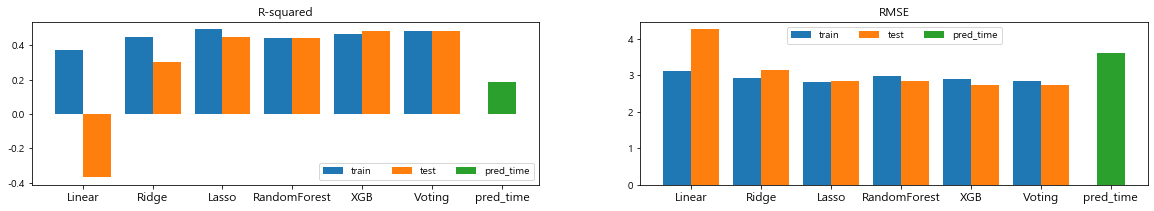

In [53]:
# 모델별 R-squred와 RMSE
x_labels = ['Linear', 'Ridge', 'Lasso', 'RandomForest', 'XGB', 'Voting', 'pred_time']
width = 0.4
ticks = np.arange(0,len(x_labels))
train_ticks = np.arange(0,len(model_eval['model'])) - width/2
test_ticks = np.arange(0,len(model_eval['model'])) + width/2

fig, ax = plt.subplots(ncols=2, figsize=(20,3))
ax[0].bar(train_ticks, model_eval['r2_train'], width=width, label='train')
ax[0].bar(test_ticks, model_eval['r2_test'], width=width, label='test')
ax[0].bar(6, r2_pred_time, width=width, label='pred_time')
ax[1].bar(train_ticks, model_eval['rmse_train'], width=width, label='train')
ax[1].bar(test_ticks, model_eval['rmse_test'], width=width, label='test')
ax[1].bar(6, rmse_pred_time, width=width, label='pred_time')
ax[0].set_xticks(ticks)
ax[1].set_xticks(ticks)
ax[0].set_xticklabels(x_labels)
ax[1].set_xticklabels(x_labels)
ax[0].legend(loc='lower right', ncol=3)
ax[1].legend(loc='upper center', ncol=3)
ax[0].tick_params(axis='x', which='major', labelsize='large', rotation=0)
ax[1].tick_params(axis='x', which='major', labelsize='large', rotation=0)
ax[0].set_title('R-squared')
ax[1].set_title('RMSE')
plt.show()

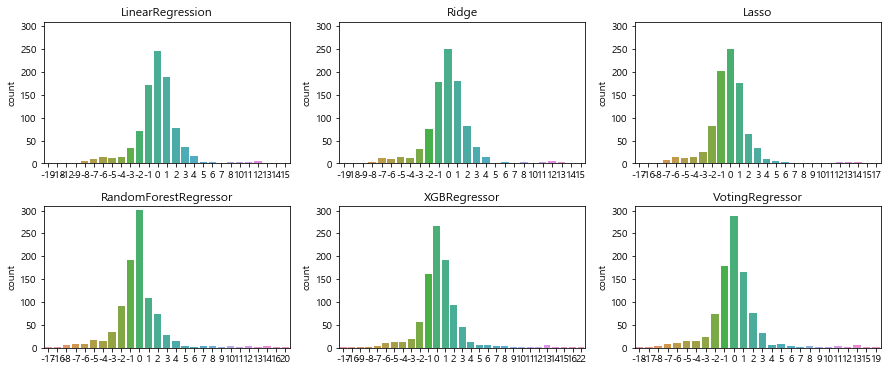

In [54]:
# 모델별 오차(y_test - predict_value) 분포
rows=2
cols=3
model_names = [model_linear, model_ridge, model_lasso, model_rf, model_xgb, model_esb]

fig = plt.figure(figsize=(15,6))
for i, model_name in zip(range(rows*cols), model_names):
    pred = model_name.predict(X_test)
    error = round(y_test - pred).astype(int)
    
    ax = fig.add_subplot(rows, cols, i+1) 
    sns.countplot(error)
    ax.set_xlabel('')
    ax.set_title(str(model_name).split('(')[0])
    ax.set_ylim([0,310])
plt.subplots_adjust(hspace = 0.3)
plt.show()

#### 트리모델 특성 중요도
- roadsectionid별 중요도 시각화
- 중요도가 높을수록 진한 색으로 표시

In [261]:
# xgb 모델
fi_xgb = pd.Series(model_xgb.feature_importances_, index=X_train.columns) # xgb 모델의 feature_importances
fi_xgb.sort_values(ascending=False, inplace=True) # 내림차순으로 정렬

fi_xgb_index = pd.Series(fi_xgb.index) # 인덱스(컬럼명, feature) 저장
fi_xgb_index = fi_xgb_index[fi_xgb_index.apply(lambda x: type(x) == int)] # int type인 컬럼(roadsectionid)만 저장

fi_xgb_value = fi_xgb.loc[fi_xgb_index] # int type인 컬럼(roadsectionid)의 중요도만 저장 
fi_xgb_value = fi_xgb_value / fi_xgb_value.iloc[0] # 중요도 전체를 가장 높은 중요도로 나눠서 0~1이 되도록 계산

# 시각화
map_suwon = folium.Map(location=(map_lat, map_lon), zoom_start=13, tiles='Stamen Terrain') 
for opacity, fi_index in zip(fi_xgb_value, fi_xgb_index):
    f_node = link_df_suwon['F_NODE'][link_df_suwon['LINK_ID']==str(fi_index)].map(coords).values[0]
    t_node = link_df_suwon['T_NODE'][link_df_suwon['LINK_ID']==str(fi_index)].map(coords).values[0]
    folium.PolyLine(locations=(f_node, t_node), color='red', line_cap='round', opacity= opacity, weight= 5,).add_to(map_suwon)
folium.CircleMarker([37.266837, 126.999346],radius=20, color='blue',fill_color='blue', popup='수원역').add_to(map_suwon)
map_suwon

In [265]:
# random forest 모델
fi_rf = pd.Series(model_rf.feature_importances_, index=X_train.columns) # xgb 모델의 feature_importances
fi_rf.sort_values(ascending=False, inplace=True) # 내림차순으로 정렬

fi_rf_index = pd.Series(fi_rf.index) # 인덱스(컬럼명, feature) 저장
fi_rf_index = fi_rf_index[fi_rf_index.apply(lambda x: type(x) == int)] # int type인 컬럼(roadsectionid)만 저장

fi_rf_value = fi_rf.loc[fi_rf_index] # int type인 컬럼(roadsectionid)의 중요도만 저장 
fi_rf_value = fi_rf_value / fi_rf_value.iloc[0] # 중요도 전체를 가장 높은 중요도로 나눠서 0~1이 되도록 계산

# 시각화
map_suwon = folium.Map(location=(map_lat, map_lon), zoom_start=13, tiles='Stamen Terrain')  
for opacity, fi_index in zip(fi_rf_value, fi_rf_index):
    f_node = link_df_suwon['F_NODE'][link_df_suwon['LINK_ID']==str(fi_index)].map(coords).values[0]
    t_node = link_df_suwon['T_NODE'][link_df_suwon['LINK_ID']==str(fi_index)].map(coords).values[0]
    folium.PolyLine(locations=(f_node, t_node), color='red', line_cap='round', opacity= opacity, weight= 5,).add_to(map_suwon)
folium.CircleMarker([37.266837, 126.999346],radius=20, color='blue',fill_color='blue', popup='수원역').add_to(map_suwon)
map_suwon

### 모델 저장
- 앙상블 모델 선택

In [55]:
import joblib
joblib.dump(model_esb, 'model/bus_info_model.pkl')

['model/bus_info_model.pkl']

In [56]:
np.savetxt("model/columns.txt", X_test.columns,fmt='%s')